In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier


In [19]:
import warnings
warnings.simplefilter('ignore')

# EDA

In [21]:
ss= pd.read_csv('sample_submission_49d68Cx.csv')
train= pd.read_csv('train_ctrUa4K.csv')
test= pd.read_csv('test_lAUu6dG.csv')

### 1. brief look at dataset

In [24]:
train.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [23]:
test.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [25]:
ID_COL,TARGET_COL='Loan_ID','Loan_Status'

In [67]:
train.describe(include='all')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,614,601,611,599,614,582,614.000000,614.000000,592.000000,600.00000,564.000000,614,614
unique,614,2,2,4,2,2,NaN,NaN,NaN,NaN,NaN,3,2
top,LP002948,Male,Yes,0,Graduate,No,NaN,NaN,NaN,NaN,NaN,Semiurban,Y
freq,1,489,398,345,480,500,NaN,NaN,NaN,NaN,NaN,233,422
mean,NaN,NaN,NaN,NaN,NaN,NaN,5403.459283,1621.245798,146.412162,342.00000,0.842199,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,6109.041673,2926.248369,85.587325,65.12041,0.364878,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,150.000000,0.000000,9.000000,12.00000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2877.500000,0.000000,100.000000,360.00000,1.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,3812.500000,1188.500000,128.000000,360.00000,1.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,5795.000000,2297.250000,168.000000,360.00000,1.000000,NaN,NaN


In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 67.2+ KB


### 2.Data set shape

In [63]:
print(f'\ndataset training data contains {train.shape[0]} rows and {train.shape[1]} columns')
print(f'\ndataset testing data contains {test.shape[0]} rows and {test.shape[1]} columns')

train=train.drop_duplicates()
test=test.drop_duplicates()

print(f'\n After removing duplicates dataset training data contains {train.shape[0]} rows and {train.shape[1]} columns')
print(f'\n After removing duplicates  dataset testing data contains {test.shape[0]} rows and {test.shape[1]} columns')


features = [c for c in train.columns if c not in [ID_COL,TARGET_COL]]
print(f'\nThe dataset contains {len(features)} features')



dataset training data contains 614 rows and 13 columns

dataset testing data contains 367 rows and 12 columns

 After removing duplicates dataset training data contains 614 rows and 13 columns

 After removing duplicates  dataset testing data contains 367 rows and 12 columns

The dataset contains 11 features


### 3. Target Distribution

In [39]:
train[TARGET_COL].value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

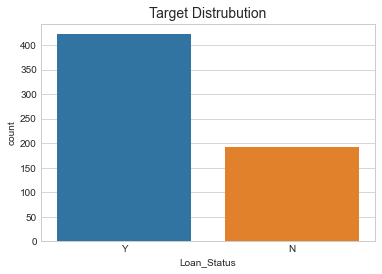

In [47]:
_= sns.countplot(train[TARGET_COL])
_=plt.title("Target Distrubution",fontsize=14)

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


### 5. Null values

In [52]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)
null_values_per_variable.sort_values(ascending=False)

Credit_History       8.1
Self_Employed        5.2
LoanAmount           3.6
Dependents           2.4
Loan_Amount_Term     2.3
Gender               2.1
Married              0.5
Loan_ID              0.0
Education            0.0
ApplicantIncome      0.0
CoapplicantIncome    0.0
Property_Area        0.0
Loan_Status          0.0
dtype: float64

### 6. Unique values in each variables

In [56]:
train.nunique()

Loan_ID              614
Gender               2  
Married              2  
Dependents           4  
Education            2  
Self_Employed        2  
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term     10 
Credit_History       2  
Property_Area        3  
Loan_Status          2  
dtype: int64

## Analyze Each Variable and its relationship

In [64]:
train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 67.2+ KB


In [72]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [80]:
cat_cols=['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area']
cat_cols

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area']

In [81]:
num_cols = [c for c in features if c not in cat_cols]
num_cols

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

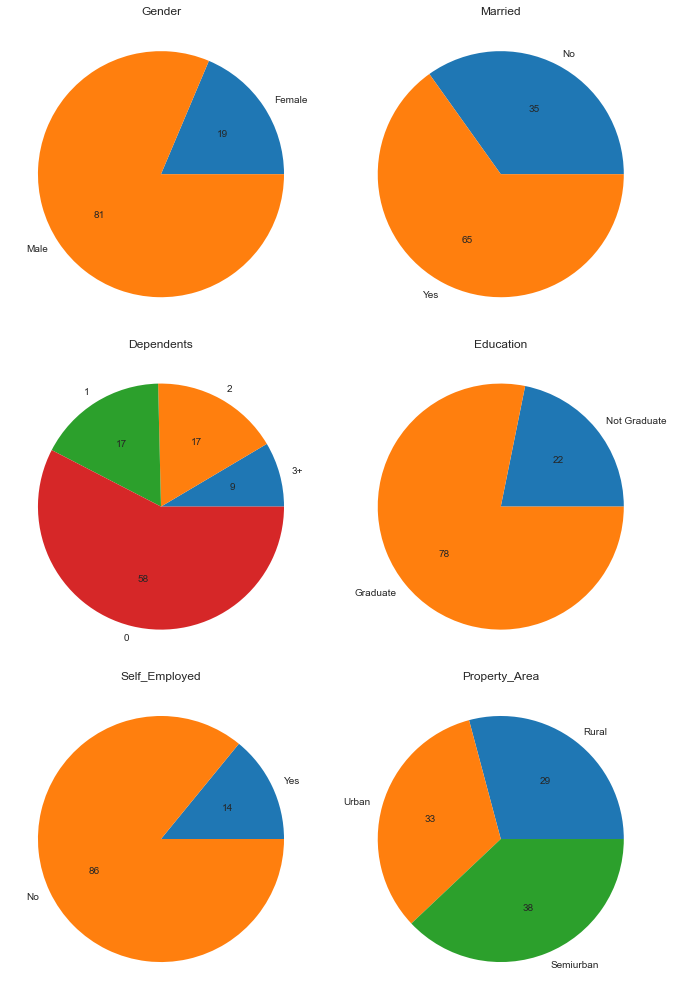

In [105]:
fig,axes = plt.subplots(3,2,figsize=(10,14))
axes = [ax for axes_row in axes for ax in axes_row]
for i,c in enumerate(train[cat_cols]):
    _=train[c].value_counts()[::-1].plot(kind='pie' , ax= axes[i], title =c,fontsize=10,autopct='%.0f')
    _=axes[i].set_ylabel('')
_=plt.tight_layout()

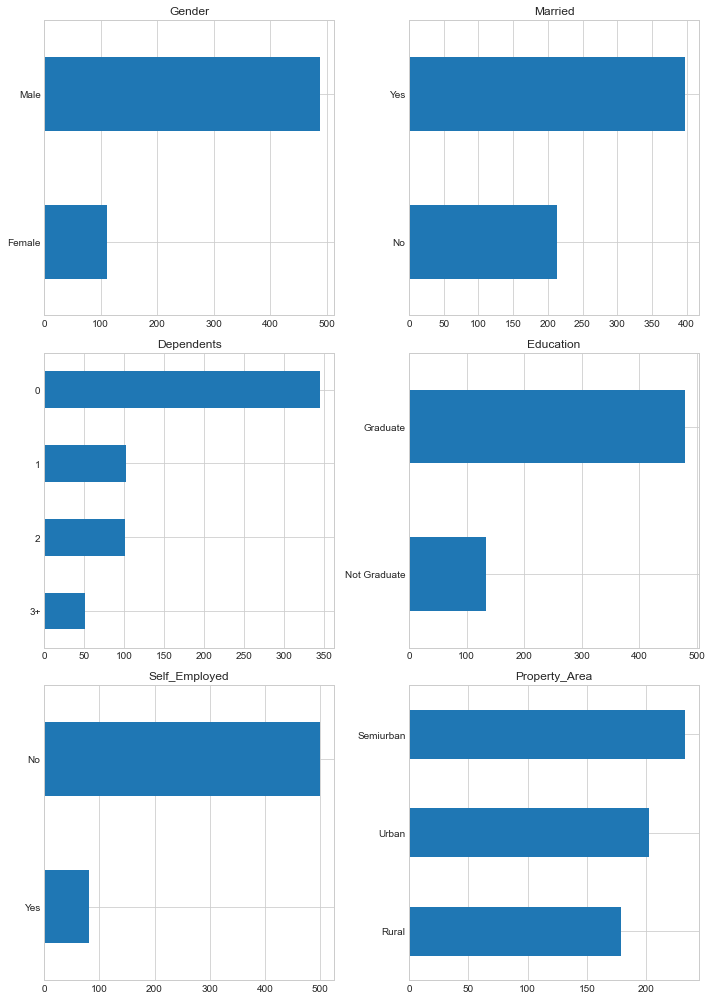

In [107]:
fig,axes = plt.subplots(3,2,figsize=(10,14))
axes = [ax for axes_row in axes for ax in axes_row]
for i,c in enumerate(train[cat_cols]):
    _=train[c].value_counts()[::-1].plot(kind='barh' , ax= axes[i], title =c,fontsize=10)
    _=axes[i].set_ylabel('')
_=plt.tight_layout()

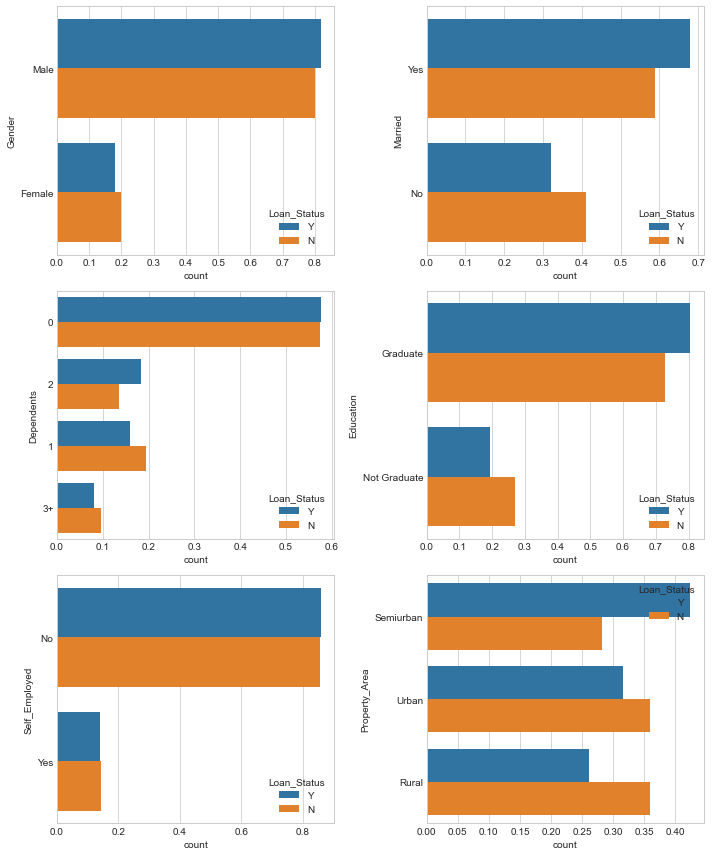

In [111]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    fltr = train[TARGET_COL] == 'Y'
    vc_a = train[fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_b = train[~fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_a[TARGET_COL] = 'Y'
    vc_b[TARGET_COL] = 'N'

    df = pd.concat([vc_a, vc_b]).reset_index(drop = True)

    _ = sns.barplot(y = c, x = 'count', data =df , hue=TARGET_COL, ax=axes[i])
    
_ = plt.tight_layout()

### Numerical Features

### 1. univariavte analysis

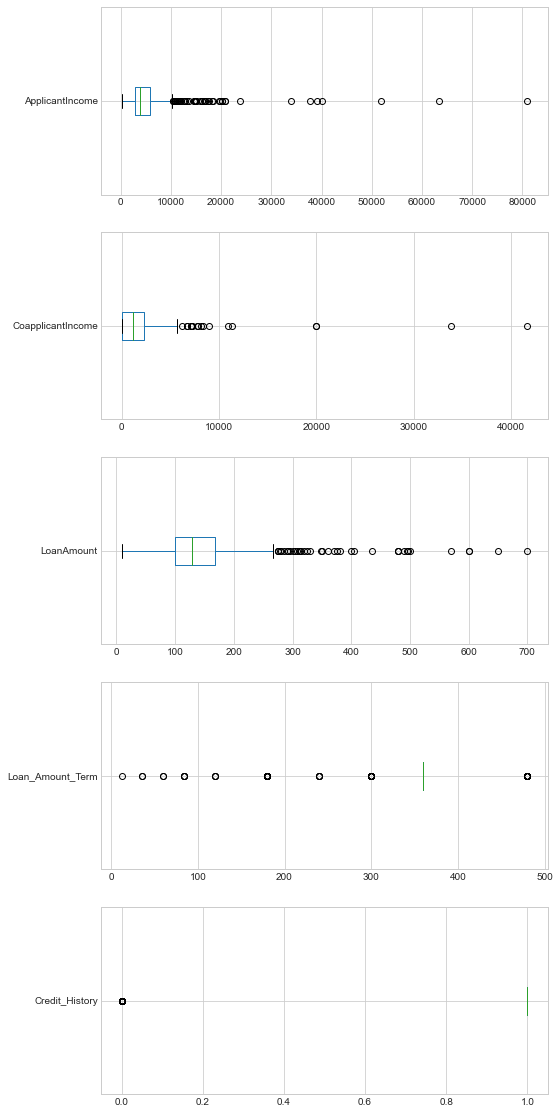

In [112]:
fig, axes = plt.subplots(5, 1, figsize=(8, 20))
for i, c in enumerate(num_cols):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

### density plot

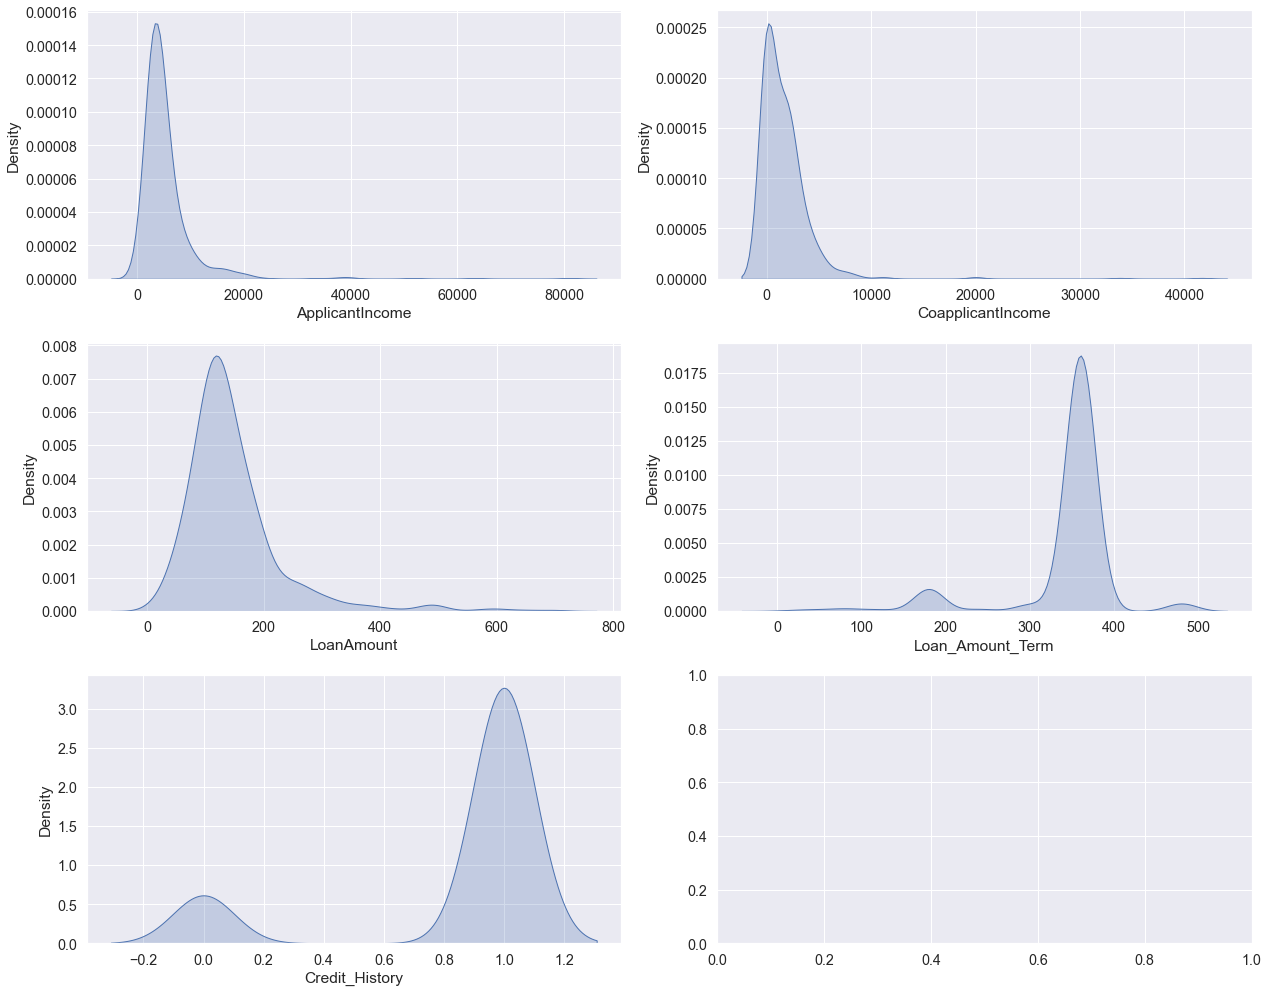

In [116]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=train, x=c, ax=axes[i], fill=True)
plt.tight_layout()

### Bivariate Analysis

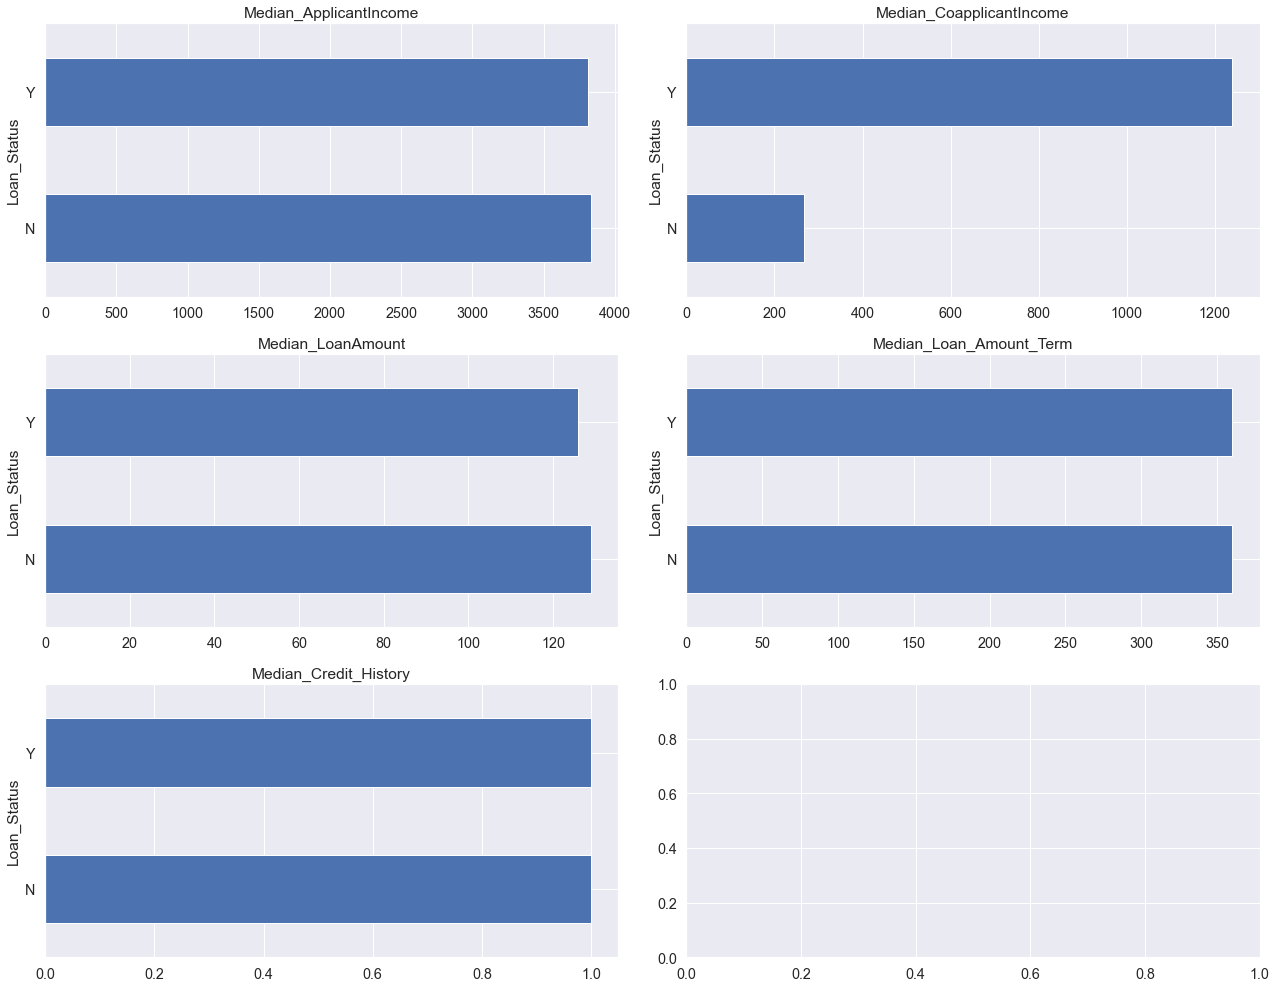

In [118]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = train.groupby(TARGET_COL)[c].median().plot(kind = 'barh', title=f'Median_{c}', ax=axes[i])
plt.tight_layout()

<Figure size 1008x576 with 0 Axes>

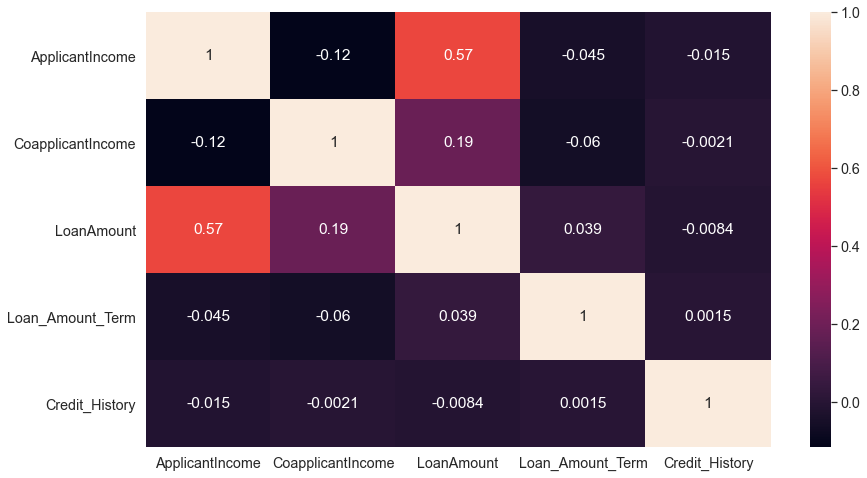

In [119]:
plt.figure(figsize=(14, 8))
_ = sns.heatmap(train[num_cols].corr(), annot=True)